## George Baltzakis P18105

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy import distance
import calendar
import helper
import bokeh.palettes as bokeh_palettes
from haversine import haversine
from sklearn.neighbors import DistanceMetric

import time

In [2]:
import os, sys

sys.path.append(os.path.join(os.path.expanduser('~'), 'ST-Visions-master'))
import st_visualizer as st_visualizer
import express as viz_express
import geom_helper as viz_helper

# <center>Import Data </center>

In [3]:
# Import the three tables
routes = pd.read_csv('bus_routes.csv', sep=';')
stops = pd.read_csv('bus_stops.csv', sep=';')
trajectories = pd.read_csv('bus_trajectories.csv', sep=',')

# Drop Duplicates
routes.drop_duplicates(inplace=True)
stops.drop_duplicates(inplace=True)
trajectories.drop_duplicates(inplace=True)

## <center>First Look of tables</center>

In [4]:
print('ROUTES table')
routes.info()
routes.head()

ROUTES table
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54551 entries, 0 to 54550
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   shape_id             54551 non-null  int64  
 1   shape_pt_lat         54551 non-null  float64
 2   shape_pt_lon         54551 non-null  float64
 3   shape_pt_sequence    54551 non-null  int64  
 4   shape_dist_traveled  52987 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 2.5 MB


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,3185,37.949377,23.637303,182,42985.0
1,3185,37.949221,23.636149,183,43087.0
2,3185,37.948560,23.635824,184,43166.0
3,3185,37.946659,23.635988,185,43378.0
4,3185,37.945976,23.635657,186,43459.0


In [5]:
print('STOPS table')
stops.info()
stops.head()

STOPS table
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7989 entries, 0 to 7988
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stop_id    7989 non-null   int64  
 1   stop_code  7989 non-null   object 
 2   stop_name  7989 non-null   object 
 3   stop_lat   7989 non-null   float64
 4   stop_lon   7989 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 374.5+ KB


,stop_id,stop_code,stop_name,stop_lat,stop_lon
0,60605,060605,ΚΑΤΕΧΑΚΗ,37.999062,23.770535
1,60607,060607,ΓΗΡΟΚΟΜΕΙΟ,37.995774,23.767887
2,60608,060608,ΕΡΥΘΡΟΣ ΣΤΑΥΡΟΣ,37.992499,23.766326
3,60610,060610,ΖΕΡΒΑ,37.989746,23.764364
4,60611,060611,ΑΜΠΕΛΟΚΗΠΟΙ,37.987389,23.761900


In [6]:
print('TRAJECTORIES table')
trajectories.info()
trajectories.head()

TRAJECTORIES table
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30818606 entries, 0 to 32012259
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   routeid    int64  
 1   vehicleid  int64  
 2   datetime   object 
 3   lat        float64
 4   lon        float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.4+ GB


,routeid,vehicleid,datetime,lat,lon
0,3376,65118,Mar 16 2020 08:55:07:000AM,37.839379,23.871029
1,3376,65152,Mar 16 2020 08:55:00:000AM,37.914188,23.900087
2,2024,7029,Mar 16 2020 08:54:53:000AM,38.005803,23.749358
3,2024,7056,Mar 16 2020 08:55:09:000AM,37.977853,23.732996
4,2024,7024,Mar 16 2020 08:45:21:000AM,38.002349,23.741560


# <center>Data Preparation</center>

### > ROUTES table

- Sort table

In [7]:
routes = routes.sort_values(by=['shape_id', 'shape_pt_sequence']).reset_index(drop=True)

### > STOPS table

- Sort table

In [8]:
stops = stops.sort_values(by=['stop_id']).reset_index(drop=True)

### > TRAJECTORIES table

- DATETIME column format

In [9]:
# Microseconds to datetime column do not need
b = True
for i in trajectories.datetime:
    if i[-5 : -2] != '000':
        b = False
        break
print('Microseconds are not important -', b)

Microseconds are not important - True


In [10]:
new_datetime = []

# Remove microseconds
for i in trajectories.datetime:
    new_datetime.append(i[:-6] + i[-2:])

# Convert datetime column, from str to datetime
trajectories.datetime = pd.to_datetime(pd.Series(new_datetime), format='%b %d %Y %I:%M:%S%p')

- Select 1 month of trajectories

In [11]:
# Data Select 2 weeks
trajectories = trajectories[(trajectories.datetime>'2020-04-01') & (trajectories.datetime<'2020-04-15')]
trajectories = trajectories.reset_index(drop=True)

- Sort table

In [12]:
# Sort values by datetime column
trajectories = trajectories.sort_values(by=['routeid', 'vehicleid', 'datetime']).reset_index(drop=True)

### Search for NULL values in all tables

In [13]:
null_values_index = []
# Search for null values
for table in [routes, stops, trajectories]:
    table_name =[x for x in globals() if globals()[x] is table][0]

    for col in table.columns:
        # Get indecies of "data DataFrame" rows, if table['col'] has null values
        null_values_index.append(table_name + '-->' + col)
        temp = table[col].index[pd.isnull(table[col])]
        if len(temp) > 0: # If null_rows_index isn't empty
            null_values_index.append(temp)
        
null_values_index 

['routes-->shape_id',
 'routes-->shape_pt_lat',
 'routes-->shape_pt_lon',
 'routes-->shape_pt_sequence',
 'routes-->shape_dist_traveled',
 Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563],
            dtype='int64', length=1564),
 'stops-->stop_id',
 'stops-->stop_code',
 'stops-->stop_name',
 'stops-->stop_lat',
 'stops-->stop_lon',
 'trajectories-->routeid',
 'trajectories-->vehicleid',
 'trajectories-->datetime',
 'trajectories-->lat',
 'trajectories-->lon']

#### So, table ROUTES has null values in SHAPE_DIST_TRAVELED column, to NULL_VALUES_INDEX[5] indecies

In [14]:
print(null_values_index[5])

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563],
           dtype='int64', length=1564)


#### About SHAPE_DIST_TRAVELED column
SHAPE_DIST_TRAVELED is the distance between points of SHAPE_PT_SEQUENCE per SHAPE_ID.
So, we can replace null values of SHAPE_DIST_TRAVELED' column as follows:
>t = null_value_index
<br>
>if SHAPE_PT_SEQUENCE[t] > 1:
<br>&emsp;&emsp;
>SHAPE_DIST_TRAVELED[t]  =  SHAPE_DIST_TRAVELED[t-1]  +  distance( (lat(t), lon(t)) , (lat(t-1), lon(t-1)) ).meters
<br>
>else:
<br>&emsp;&emsp;
>dist[t] = 0

In [15]:
# Replace null values
for index in null_values_index[5]:
    if routes.at[index, 'shape_pt_sequence'] > 1:
        routes.at[index, 'shape_dist_traveled'] = \
        routes.at[index-1, 'shape_dist_traveled'] + \
        int( distance.distance((routes.at[index, 'shape_pt_lat'], routes.at[index, 'shape_pt_lon']), \
        (routes.at[index-1, 'shape_pt_lat'], routes.at[index-1, 'shape_pt_lon'])).m)
    else: # The start point
        routes.at[index, 'shape_dist_traveled'] = 0

# No null values left

In [16]:
# From DataFrame to GeoDataFrame
routes = helper.getGeoDataFrame_v2(routes, coordinate_columns=['shape_pt_lon', 'shape_pt_lat'], crs='epsg:4326')
stops = helper.getGeoDataFrame_v2(stops, coordinate_columns=['stop_lon', 'stop_lat'], crs='epsg:4326')
trajectories = helper.getGeoDataFrame_v2(trajectories, crs='epsg:4326')

In [17]:
# Visualization of Trajectories
st_viz = st_visualizer.st_visualizer()
st_viz.set_data(trajectories.head(500_000))
viz_express.plot_points_on_map(st_viz, tools=['lasso_select'])
st_viz.add_temporal_filter(temporal_name='datetime', temporal_unit='ms', callback_policy='value_throttled', step_ms=5*60*10**3, title='Temporal Horizon')
st_viz.show_figures(notebook_url='http://localhost:8888')

Loading BokehJS ...

# <center>Data Cleansing</center>

In [18]:
# Remove duplicate points
trajectories.drop_duplicates(subset=['datetime','vehicleid'], inplace=True)

print ('Step 1. Calculating Speed')
# Calculate speed
calc_velocity = trajectories.copy().groupby('vehicleid', group_keys=False).apply(lambda gdf: helper.calculate_velocity(gdf, ts_column='datetime'))['velocity']

print ('Step 2. Calculating Bearing')
# Calculate bearing
calc_heading = trajectories.copy().groupby('vehicleid', group_keys=False).apply(lambda gdf: helper.calculate_bearing(gdf))['bearing']

print ('Step 3. Concatenating Results')
trajectories.loc[:, 'velocity'] = calc_velocity
trajectories.loc[:, 'bearing'] = calc_heading

print ('Step 4. Calculating Acceleration')
# Calculate acceleration
trajectories.loc[:, 'acceleration'] = trajectories.groupby('vehicleid', group_keys=False).apply(lambda gdf: helper.calculate_acceleration(gdf, ts_column='datetime'))

# Drop NaN values (in case they exist)
trajectories.dropna(subset=['velocity', 'bearing', 'acceleration'], inplace=True)

Step 1. Calculating Speed
Step 2. Calculating Bearing
Step 3. Concatenating Results
Step 4. Calculating Acceleration


### Spatial Outliers

In [19]:
vehicle_traj_gdf = trajectories[trajectories.vehicleid.isin(trajectories.vehicleid.unique()[:2])].copy()

tmp = []
for i in range(1, len(vehicle_traj_gdf)):
    tmp.append(haversine((vehicle_traj_gdf.geom.x.iloc[i], vehicle_traj_gdf.geom.y.iloc[i]) , (vehicle_traj_gdf.geom.x.iloc[i-1], vehicle_traj_gdf.geom.y.iloc[i-1])))
vehicle_traj_gdf.loc[:, 'distance_from_prev'] = pd.Series(tmp)
vehicle_traj_gdf.loc[:, 'temporal_difference_from_prev'] = vehicle_traj_gdf.datetime.diff().abs()

In [35]:
# 54 knots = 100 kph
curr_pts = vehicle_traj_gdf[vehicle_traj_gdf.velocity >= 54].index
prev_pts = vehicle_traj_gdf[vehicle_traj_gdf.velocity >= 54].index - 1
next_pts = vehicle_traj_gdf[vehicle_traj_gdf.velocity >= 54].index + 1

sub_traj_of_interest = vehicle_traj_gdf.loc[np.sort(np.concatenate((prev_pts, next_pts, curr_pts)))].drop_duplicates(subset=['vehicleid', 'datetime'])
sub_traj_of_interest.head(7).style.apply(lambda l: helper.highlight_outliers(l, curr_pts), axis=1)

,routeid,vehicleid,datetime,lat,lon,geom,velocity,bearing,acceleration,distance_from_prev,temporal_difference_from_prev
227,1962,7001,2020-04-05 06:37:10,38.033134,23.693232,POINT (23.693232000000002 38.033134000000004),8.264836,179.955808,-0.645617,0.607984,0 days 00:12:52
228,1962,7001,2020-04-05 06:43:04,38.019598,23.693243,POINT (23.693243 38.019597999999995),236.813330,156.786789,19.574330,1.529026,0 days 00:05:54
229,1962,7001,2020-04-05 06:43:16,38.007206,23.698818,POINT (23.698818 38.007206),1.921365,44.041044,-0.016359,1.590702,0 days 00:00:12
606,2019,7001,2020-04-08 20:03:41,37.966209,23.728943,POINT (23.728943 37.966209),13.315916,14.629306,-0.458236,6.899414,0 days 00:04:48
607,2019,7001,2020-04-08 20:07:39,37.980546,23.732839,POINT (23.732839000000002 37.980546000000004),122.376105,299.932566,5.822709,0.516016,0 days 00:03:58
608,2019,7001,2020-04-08 20:08:00,37.987353,23.720471,POINT (23.720471 37.987353000000006),0.099212,324.505023,-0.000017,1.642794,0 days 00:00:21
805,2013,7001,2020-04-13 15:38:05,37.995425,23.750192,POINT (23.750192000000002 37.995425),13.116899,250.427789,-0.578169,1.536182,0 days 00:04:40


### Remove the Outliers

In [36]:
trajectories = trajectories.loc[trajectories.velocity < 54].copy()
trajectories.reset_index(drop=True, inplace=True)

### Apply R-Tree Spatial Index

In [22]:
sindex = trajectories.sindex

### Select routes which exists in table TRAJECTORIES

In [23]:
routes = routes[routes.shape_id.isin(trajectories.routeid)].reset_index(drop=True)
routes.drop_duplicates(['shape_id', 'geom'], inplace=True)

### Save Tables

In [24]:
trajectories.to_csv('meta_trajectories.csv', index=False)
routes.to_csv('meta_routes.csv', index=False)
stops.to_csv('meta_stops.csv', index=False)

In [25]:
trajectories.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1337595 entries, 0 to 1337594
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   routeid       1337595 non-null  int64         
 1   vehicleid     1337595 non-null  int64         
 2   datetime      1337595 non-null  datetime64[ns]
 3   lat           1337595 non-null  float64       
 4   lon           1337595 non-null  float64       
 5   geom          1337595 non-null  geometry      
 6   velocity      1337595 non-null  float64       
 7   bearing       1337595 non-null  float64       
 8   acceleration  1337595 non-null  float64       
dtypes: datetime64[ns](1), float64(5), geometry(1), int64(2)
memory usage: 91.8 MB


# <center>Statistics & Visualization</center>

### Number of vehicles in _TRAJECTORIES_ table

In [26]:
len(trajectories.vehicleid.unique())

1350

### Average Number of BUSES signals per day

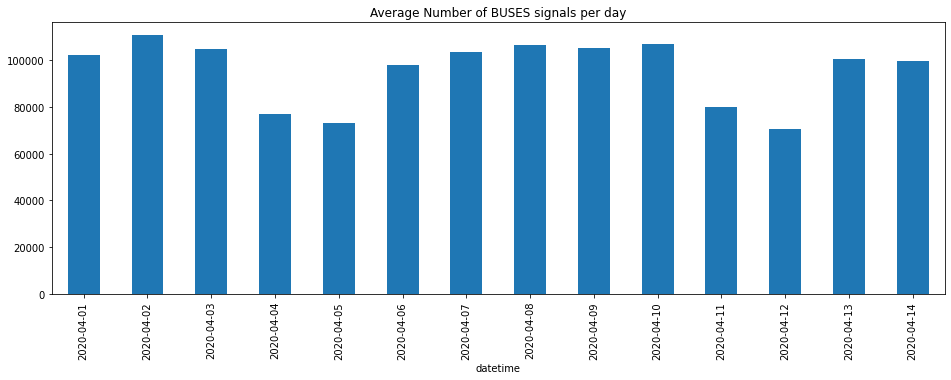

In [27]:
average_number_of_buses_signals_per_day = trajectories.groupby([pd.to_datetime(trajectories.datetime,unit="s").dt.date]).apply(len)
average_number_of_buses_signals_per_day.head()

plt.figure(figsize=(16, 5))
plt.title('Average Number of BUSES signals per day')
average_number_of_buses_signals_per_day.plot(kind='bar')
plt.show()

### Number of records per bus (vehicleid column)

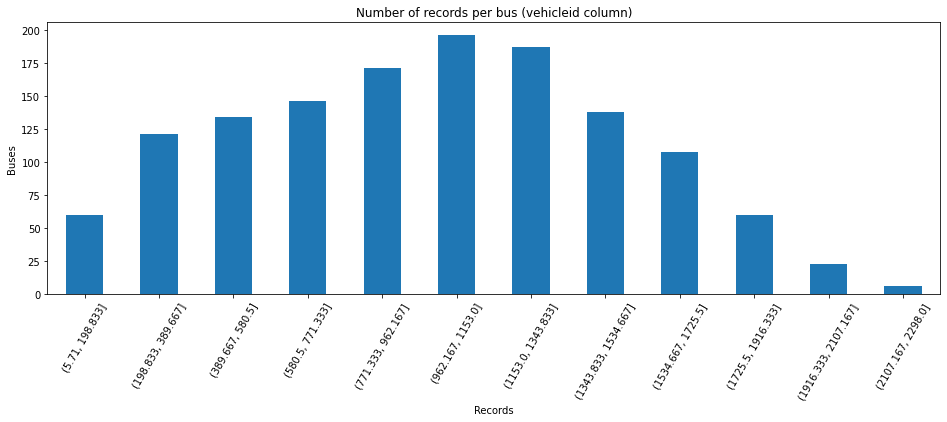

In [28]:
number_of_records_per_bus = trajectories.groupby('vehicleid').apply(len)
number_of_records_per_bus.head()

out = pd.cut(number_of_records_per_bus, 12) 
ax = out.value_counts(sort=False).plot.bar(figsize=(16,5), rot=60)
plt.title('Number of records per bus (vehicleid column)')
plt.xlabel('Records')
plt.ylabel('Buses')
plt.show()

### Mean number of records per Vehicle at daily basis

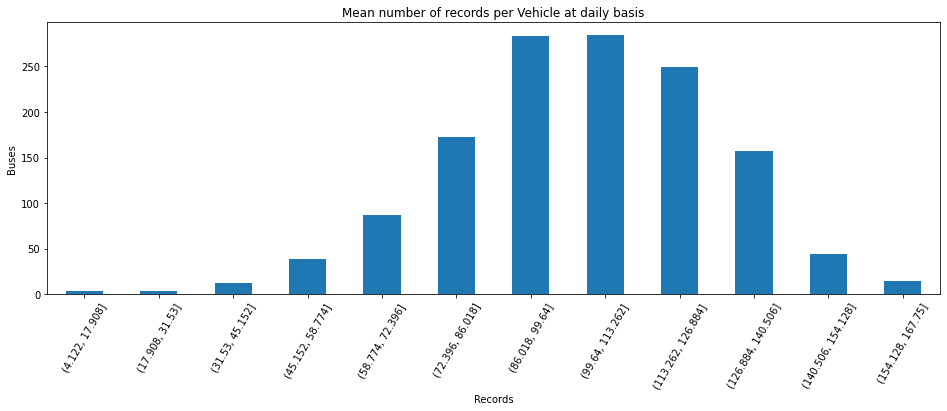

In [29]:
number_of_records_per_bus_per_day = trajectories.groupby([trajectories.vehicleid, pd.to_datetime(trajectories.datetime, unit='s').dt.date]).apply(len)
number_of_records_per_bus_per_day = number_of_records_per_bus_per_day.groupby('vehicleid').apply(lambda x: x.sum()/len(x))
number_of_records_per_bus_per_day.head()

out = pd.cut(number_of_records_per_bus_per_day, 12) 
ax = out.value_counts(sort=False).plot.bar(figsize=(16,5), rot=60)
plt.title('Mean number of records per Vehicle at daily basis')
plt.xlabel('Records')
plt.ylabel('Buses')
plt.show()

### Number of records per weekday

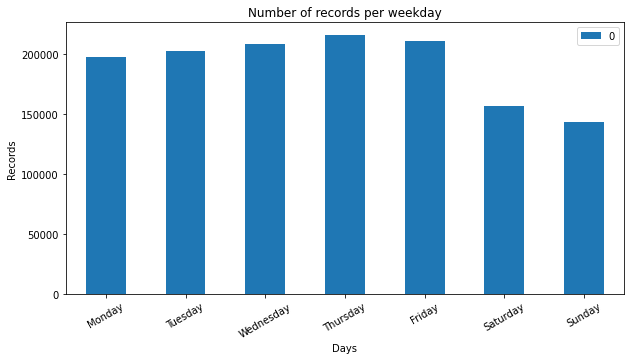

In [30]:
num_of_records_per_day = trajectories.groupby([pd.to_datetime(trajectories.datetime, unit="s").dt.date]).apply(len).to_frame().reset_index()
num_of_records_per_day.loc[:, 'day_name'] = pd.to_datetime(num_of_records_per_day.datetime).dt.day_name()
num_of_records_per_day.loc[:, 'day_name'] = pd.Categorical(num_of_records_per_day.day_name, categories=list(calendar.day_name), ordered=True)
num_of_records_per_day.sort_values('day_name', inplace=True)
num_of_records_per_day = num_of_records_per_day.groupby('day_name').apply(sum)
num_of_records_per_day.drop('day_name', axis=1, inplace=True)

num_of_records_per_day.plot.bar(figsize=(10,5), rot=30)
plt.title('Number of records per weekday')
plt.xlabel('Days')
plt.ylabel('Records')
plt.show()

### Velocity plot

/Users/Giorgos/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


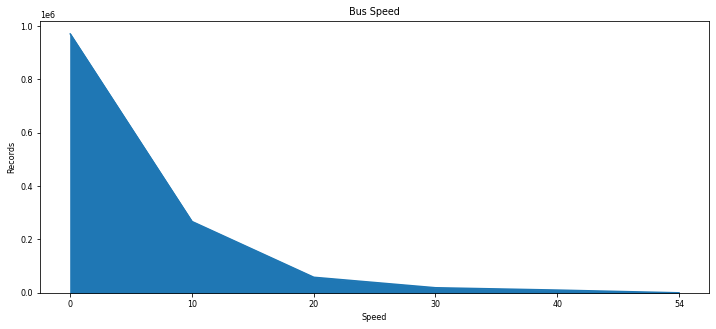

In [37]:
out = pd.cut(trajectories.velocity, [0, 10, 20, 30, 40, np.round(trajectories.velocity.max()), np.round(trajectories.velocity.max())+2])
ax = out.value_counts(sort=False).plot.area(figsize=(12,5))
ax.set_xticklabels([''] + out.cat.categories.left.values.astype(int).tolist() + [''])

plt.title('Bus Speed')
plt.xlabel('Speed')
plt.ylabel('Records')
plt.show()

### Acceleration plot

/Users/Giorgos/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


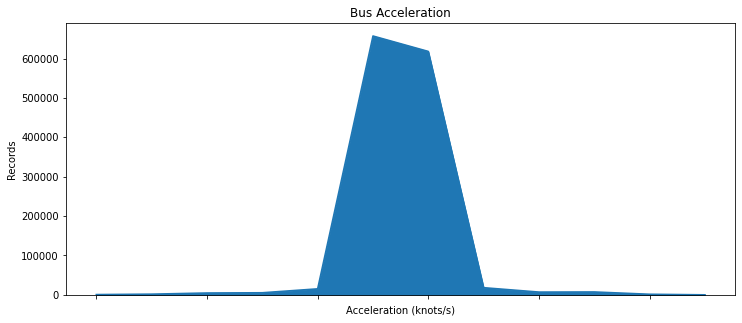

In [32]:
no_of_bins=[-2900, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 94] 


out = pd.cut(trajectories.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(12, 5))

plt.title('Bus Acceleration')
plt.xlabel('Acceleration (knots/s)')
plt.ylabel('Records')
plt.show()

### Bearing plot

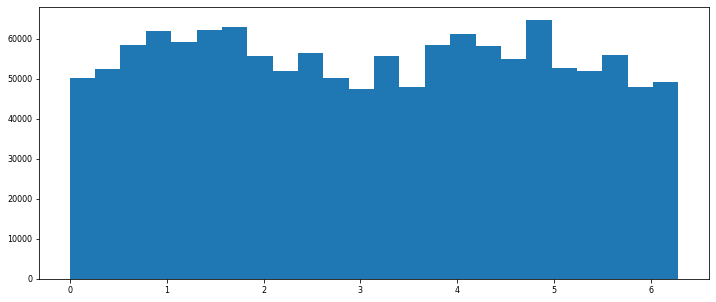

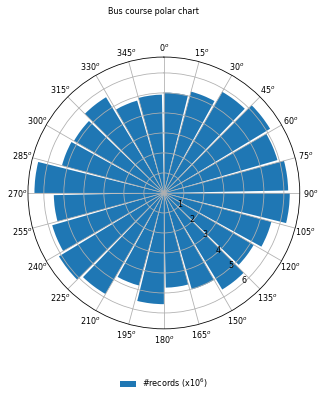

ERROR:tornado.application:Uncaught exception GET /ws (::1)
HTTPServerRequest(protocol='http', host='localhost:51265', method='GET', uri='/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/Users/Giorgos/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/Users/Giorgos/opt/anaconda3/envs/tf/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 135, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
ERROR:tornado.application:Uncaught exception GET /ws (::1)
HTTPServerRequest(protocol='http', host='localhost:51265', method='GET', uri='/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/Users/Giorgos/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = 

In [33]:
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [12, 5]

bins_number = 24  # the [0, 360) interval will be subdivided into this number of equal bins
degree_intervals = 15

fig, ax = plt.subplots()
ax, lines, labels = helper.create_radial_chart(ax, trajectories, bins_number, degree_intervals)

ax.legend([r'#records (x$10^6$)'], frameon=False, fancybox=False, shadow=False, loc='lower center', bbox_to_anchor=(0.5, -0.25))
plt.show()